# Compositional analysis

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

import scanpy as sc

2022-03-31 16:00:53.579448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 16:00:53.579487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
adata_f = '/storage/scratch/users/ciro.suastegui/ipsc_ipd_patients_final.h5ad'
adata_f = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_final.h5ad'

In [3]:
adata = sc.read(adata_f)

In [4]:
adata

AnnData object with n_obs × n_vars = 30557 × 24920
    obs: 'Demux_state', 'Donor', 'Lane', 'Number of genes', 'Total counts', 'age', 'condition', 'donor', 'gender', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'total_counts', 'years_of_illness', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_final', 'Ferroptosis_pos_raw', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_raw', 'Ferroptosis_neg_corr', 'Apoptosis_pos_raw', 'Apoptosis_pos_corr', 'Apoptosis_neg_raw', 'Apoptosis_neg_corr', 'Necroptosis_pos_raw', 'Necroptosis_pos_corr', 'Autophagy_pos_raw', 'Autophagy_pos_corr', 'Pathanatos_pos_raw', 'Pathanatos_pos_corr', 'louvain_final_abbrev'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'condition_colors', 'gender_colors', 'louvain', 'louvain_final_abbrev_colors', 'louvai

### Create object

In [5]:
adata.obs['Donor_condition'] = adata.obs['Donor'].astype(str) + '_' + adata.obs['condition'].astype(str)
cell_counts = pd.crosstab(adata.obs.Donor_condition, adata.obs.louvain_final)
cell_counts['Donor_condition'] = cell_counts.index.tolist()
cell_counts.reset_index(drop=True, inplace=True)
cell_counts

louvain_final,Glial precursors,Immature neurons,NCSC,NSC1a,NSC1b,NSC2a,NSC2b,Apop. NCSC,Apop. NSC,Donor_condition
0,54,21,2350,181,100,534,112,63,31,UKERi1E4-R1-003_Control
1,0,28,6,273,271,677,111,0,28,UKERi1JF-R1-018_Control
2,0,13,383,82,81,124,67,46,56,UKERi82A-R1-002_Control
3,96,39,723,667,435,789,419,59,52,UKERi88H-R1-002_Parkinson
4,204,76,373,841,884,219,121,14,247,UKERiAY6-R1-003_Parkinson
5,220,45,290,1449,1267,762,372,12,165,UKERiC99-R1-007_Parkinson
6,98,25,13,1680,733,361,99,0,223,UKERiG3G-R1-039_Control
7,22,69,273,553,687,187,70,5,297,UKERiJ2C-R1-015_Parkinson
8,0,6,66,345,199,292,93,0,33,UKERiM89-R1-005_Parkinson
9,1,18,1,1629,675,275,63,1,83,UKERiO3H-R1-005_Control


In [6]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Donor_condition"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Donor_condition"].str.replace(r".*_", "")
print(data_all)

AnnData object with n_obs × n_vars = 12 × 9
    obs: 'Donor_condition', 'Condition'


In [7]:
data_all.obs

louvain_final,Donor_condition,Condition
0,UKERi1E4-R1-003_Control,Control
1,UKERi1JF-R1-018_Control,Control
2,UKERi82A-R1-002_Control,Control
3,UKERi88H-R1-002_Parkinson,Parkinson
4,UKERiAY6-R1-003_Parkinson,Parkinson
5,UKERiC99-R1-007_Parkinson,Parkinson
6,UKERiG3G-R1-039_Control,Control
7,UKERiJ2C-R1-015_Parkinson,Parkinson
8,UKERiM89-R1-005_Parkinson,Parkinson
9,UKERiO3H-R1-005_Control,Control


<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

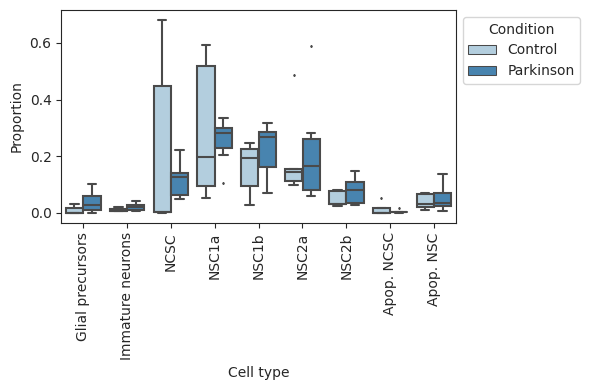

In [8]:
viz.boxplots(data_all, feature_name="Condition")
plt.savefig('figures/sccoda_boxplot.pdf', bbox_inches='tight')
plt.show()

### Create the model
And run inference on it.

In [9]:
model_all = mod.CompositionalAnalysis(data_all, formula="Condition", reference_cell_type="automatic")

Automatic reference selection! Reference cell type set to Immature neurons


2022-03-31 16:10:51.838004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 16:10:51.922886: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 16:10:51.923025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (icb-neu-002.scidom.de): /proc/driver/nvidia/version does not exist


Zero counts encountered in data! Added a pseudocount of 0.5.


2022-03-31 16:10:52.444665: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


HMC sampling is then initiated.

In [13]:
# Run MCMC
sim_results = model_all.sample_hmc()

2022-03-09 14:43:55.690476: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f4684010300 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-09 14:43:55.690524: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
  0%|          | 0/20000 [00:00<?, ?it/s]2022-03-09 14:43:55.752578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-03-09 14:43:56.610605: I tensorflow/compiler/jit/xla_compilation_cache.cc:399] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 20000/20000 [01:26<00:00, 231.45it/s]


MCMC sampling finished. (110.078 sec)
Acceptance rate: 58.4%


### Interpretation

_Intercepts_ show how the cell types are distributed without any active covariates. _Effects_ show how the covariates influence the cell types.

In [14]:
sim_results.summary()

Compositional Analysis summary:

Data: 12 samples, 9 cell types
Reference index: 2
Formula: Condition

Intercepts:
                  Final Parameter  Expected Sample
Cell Type                                         
Glial precursors           -1.034        85.851885
Immature neurons           -0.749       114.162576
NCSC                       -0.055       228.519955
NSC1a                       0.992       651.074151
NSC1b                       0.710       491.088099
NSC2a                       0.741       506.550255
NSC2b                      -0.048       230.125207
Apop. NCSC                 -1.342        63.093865
Apop. NSC                  -0.315       176.200674


Effects:
                                         Final Parameter  Expected Sample  \
Covariate              Cell Type                                            
Condition[T.Parkinson] Glial precursors              0.0        85.851885   
                       Immature neurons              0.0       114.162576   
     

In [15]:
print(sim_results.credible_effects())

Covariate               Cell Type       
Condition[T.Parkinson]  Glial precursors    False
                        Immature neurons    False
                        NCSC                False
                        NSC1a               False
                        NSC1b               False
                        NSC2a               False
                        NSC2b               False
                        Apop. NCSC          False
                        Apop. NSC           False
Name: Final Parameter, dtype: bool


### Adjusting the False discovery rate

Credible and non-credible effects depends on the false discovery rate (FDR).
Default is 0.05 but we can increase it to be less conservative. We'll use 0.4, a common threshold in medical science.

In [16]:
sim_results.set_fdr(est_fdr=0.4)
sim_results.summary()

Compositional Analysis summary:

Data: 12 samples, 9 cell types
Reference index: 2
Formula: Condition

Intercepts:
                  Final Parameter  Expected Sample
Cell Type                                         
Glial precursors           -1.034        85.851885
Immature neurons           -0.749       114.162576
NCSC                       -0.055       228.519955
NSC1a                       0.992       651.074151
NSC1b                       0.710       491.088099
NSC2a                       0.741       506.550255
NSC2b                      -0.048       230.125207
Apop. NCSC                 -1.342        63.093865
Apop. NSC                  -0.315       176.200674


Effects:
                                         Final Parameter  Expected Sample  \
Covariate              Cell Type                                            
Condition[T.Parkinson] Glial precursors              0.0        85.851885   
                       Immature neurons              0.0       114.162576   
     

In [17]:
print(sim_results.credible_effects())

Covariate               Cell Type       
Condition[T.Parkinson]  Glial precursors    False
                        Immature neurons    False
                        NCSC                False
                        NSC1a               False
                        NSC1b               False
                        NSC2a               False
                        NSC2b               False
                        Apop. NCSC          False
                        Apop. NSC           False
Name: Final Parameter, dtype: bool


## Saving results

In [18]:
# saving
path = "/storage/groups/ml01/workspace/ciro.suastegui/2019_wurst_demuxlet/processed_data/sccoda"
sim_results.save(path)

# loading
with open(path, "rb") as f:
    sim_results_2 = pkl.load(f)

sim_results_2.summary()

Compositional Analysis summary:

Data: 12 samples, 9 cell types
Reference index: 2
Formula: Condition

Intercepts:
                  Final Parameter  Expected Sample
Cell Type                                         
Glial precursors           -1.034        85.851885
Immature neurons           -0.749       114.162576
NCSC                       -0.055       228.519955
NSC1a                       0.992       651.074151
NSC1b                       0.710       491.088099
NSC2a                       0.741       506.550255
NSC2b                      -0.048       230.125207
Apop. NCSC                 -1.342        63.093865
Apop. NSC                  -0.315       176.200674


Effects:
                                         Final Parameter  Expected Sample  \
Covariate              Cell Type                                            
Condition[T.Parkinson] Glial precursors              0.0        85.851885   
                       Immature neurons              0.0       114.162576   
     